In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import netCDF4
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import sklearn
from sklearn.model_selection import KFold
import cartopy.crs as ccrs
import glob
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
###latitude indices
la=6
lb=30

In [4]:
### first load 50 uncertainty-sampled realizations of SWOOSH 30N-30S, see file 1) create_SWOOSH_time_series.ipynb
swoosh_tropics_processed = netCDF4.Dataset('./data/swoosh/SWOOSH_samples_scaleSE_1.0_scaleB_1.0_nsamples_50_aura5_finalNatGeo.nc')['samples'][:,:]
### extract months/indices with data
non_nan_indices = np.argwhere(~np.isnan(swoosh_tropics_processed[:,0])).T
print(non_nan_indices[:])
print(swoosh_tropics_processed.shape)

[[ 72  86  87  88  92  93  94  95  96  97  98  99 100 101 102 103 104 105
  106 107 108 109 110 111 114 116 117 118 120 121 122 123 124 126 127 128
  129 130 132 134 135 136 138 140 141 142 144 146 147 150 152 153 154 155
  156 157 158 159 161 163 164 165 167 168 169 170 171 173 174 175 176 177
  179 181 182 183 185 187 188 189 191 193 194 195 197 199 200 201 203 205
  206 207 209 211 212 213 214 215 217 218 219 220 221 223 226 228 229 230
  232 233 234 235 237 238 240 241 244 246 247 248 249 250 251 252 253 254
  255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272
  273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290
  291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308
  309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326
  327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344
  345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362
  363 364 365 366 367 368 369 370 371 

In [5]:
### load ERA5 data for temperature
nt_train_end=444
nt_train_start=0
### make sure to sub-select the inner five pressure levels (2nd array dimension); files contain data for seven pressure levels
era_ta = netCDF4.Dataset('./data/cmip/ta/ta_ERA5_1984_01_2020_12.nc')['t'][nt_train_start:nt_train_end,1:-1,la:lb,:]
era_level = netCDF4.Dataset('./data/cmip/ta/ta_ERA5_1984_01_2020_12.nc')['level'][1:-1]
era_lat = netCDF4.Dataset('./data/cmip/ta/ta_ERA5_1984_01_2020_12.nc')['lat'][la:lb]
era_lon = netCDF4.Dataset('./data/cmip/ta/ta_ERA5_1984_01_2020_12.nc')['lon'][:]
### extract one CMIP reference case; cdo was used beforehand to regrid all data (reanalyses; CMIP5/6 models) to the same spatial resolution 
cmip_level = netCDF4.Dataset('./data/cmip/ta/ta_Amon_ACCESS1-0_historical-rcp45_r1i1p1.nc')['plev'][1:-1]
cmip_lat = netCDF4.Dataset('./data/cmip/ta/ta_Amon_ACCESS1-0_historical-rcp45_r1i1p1.nc')['lat'][la:lb]
cmip_lon = netCDF4.Dataset('./data/cmip/ta/ta_Amon_ACCESS1-0_historical-rcp45_r1i1p1.nc')['lon'][:]

In [6]:
### load MERRA2 for temperature
merra_ta = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_MERRA2_198401-201912_5x5_7levels.nc')['ta'][nt_train_start:nt_train_end,1:-1,la:lb,:]
merra_level = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_MERRA2_198401-201912_5x5_7levels.nc')['plev'][1:-1]/100.0
merra_lat = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_MERRA2_198401-201912_5x5_7levels.nc')['lat'][la:lb]
merra_lon = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_MERRA2_198401-201912_5x5_7levels.nc')['lon'][:]

In [7]:
### load JRA-55 for temperature
jra_ta = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_JRA-55_198401-202012_5x5_7levels.nc')['ta'][nt_train_start:nt_train_end,1:-1,la:lb,:]
jra_level = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_JRA-55_198401-202012_5x5_7levels.nc')['plev'][1:-1]/100.0
jra_lat = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_JRA-55_198401-202012_5x5_7levels.nc')['lat'][la:lb]
jra_lon = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_JRA-55_198401-202012_5x5_7levels.nc')['lon'][:]

In [8]:
merra_level

masked_array(data=[250.0, 200.0, 150.0, 100.0, 70.0],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

In [9]:
jra_level

masked_array(data=[250.0, 200.0, 150.0, 100.0, 70.0],
             mask=[False, False, False, False, False],
       fill_value=1e+20,
            dtype=float32)

In [10]:
era_level

masked_array(data=[ 70., 100., 150., 200., 250.],
             mask=False,
       fill_value=1e+20)

In [11]:
### MERRA is missing year 2020
merra_ta.shape

(432, 5, 24, 72)

In [12]:
jra_ta.shape

(444, 5, 24, 72)

In [13]:
### flip vertical axis for ERA5 to match CMIP models
era_ta = np.flip(era_ta,axis=1)

In [14]:
era_ta.shape

(444, 5, 24, 72)

In [15]:
### check this matches the CMIP output order
cmip_level

masked_array(data=[25000., 20000., 15000., 10000.,  7000.],
             mask=False,
       fill_value=1e+20)

In [16]:
### check we have the same lat selection for the reanalyses and CMIP models
print(era_lat)
print(cmip_lat)

[-57.5 -52.5 -47.5 -42.5 -37.5 -32.5 -27.5 -22.5 -17.5 -12.5  -7.5  -2.5
   2.5   7.5  12.5  17.5  22.5  27.5  32.5  37.5  42.5  47.5  52.5  57.5]
[-57.5 -52.5 -47.5 -42.5 -37.5 -32.5 -27.5 -22.5 -17.5 -12.5  -7.5  -2.5
   2.5   7.5  12.5  17.5  22.5  27.5  32.5  37.5  42.5  47.5  52.5  57.5]


In [17]:
### same for longitudes (#all)
print(era_lon)
print(cmip_lon)

[-177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 -142.5 -137.5 -132.5
 -127.5 -122.5 -117.5 -112.5 -107.5 -102.5  -97.5  -92.5  -87.5  -82.5
  -77.5  -72.5  -67.5  -62.5  -57.5  -52.5  -47.5  -42.5  -37.5  -32.5
  -27.5  -22.5  -17.5  -12.5   -7.5   -2.5    2.5    7.5   12.5   17.5
   22.5   27.5   32.5   37.5   42.5   47.5   52.5   57.5   62.5   67.5
   72.5   77.5   82.5   87.5   92.5   97.5  102.5  107.5  112.5  117.5
  122.5  127.5  132.5  137.5  142.5  147.5  152.5  157.5  162.5  167.5
  172.5  177.5]
[-177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 -142.5 -137.5 -132.5
 -127.5 -122.5 -117.5 -112.5 -107.5 -102.5  -97.5  -92.5  -87.5  -82.5
  -77.5  -72.5  -67.5  -62.5  -57.5  -52.5  -47.5  -42.5  -37.5  -32.5
  -27.5  -22.5  -17.5  -12.5   -7.5   -2.5    2.5    7.5   12.5   17.5
   22.5   27.5   32.5   37.5   42.5   47.5   52.5   57.5   62.5   67.5
   72.5   77.5   82.5   87.5   92.5   97.5  102.5  107.5  112.5  117.5
  122.5  127.5  132.5  137.5  142.5  147.5  152.5  157.5  162

In [18]:
nr_lat=len(cmip_lat)
nr_lon=72
nr_planes=7
### alpha range slightly adjusted for what's needed for observations
alpha_i=[0.01,0.03,0.1,0.3,1,2,4,6,8,10,12,14,16,18,20,25,30,40,50,60,70,80,90,100,150,200,250,300,400,500,600,700,800,900,1000,3000,5000,10000,12000,14000,16000,18000,20000,25000,30000,50000,100000,150000,200000,250000,300000,400000,500000,600000,700000,800000,900000,1e6,3e6,1e7,3e7,1e8,3e8,1e9,3e9]

In [19]:
era_ta.shape

(444, 5, 24, 72)

In [20]:
### reformat temperature reanalysis data in X matrices as required for ridge regression
X_raw_hist_era5 = era_ta.reshape(era_ta.shape[0],nr_lon*nr_lat*(nr_planes-2))
X_raw_hist_merra = merra_ta.reshape(merra_ta.shape[0],nr_lon*nr_lat*(nr_planes-2))
X_raw_hist_jra = jra_ta.reshape(jra_ta.shape[0],nr_lon*nr_lat*(nr_planes-2))

In [21]:
### adjust non-masked indices to consideration of lag 2 for temperature predictors
lag=2
non_nan_indices = non_nan_indices.flatten()
non_nan_indices_lag = non_nan_indices-lag

In [22]:
non_nan_indices_lag

array([ 70,  84,  85,  86,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 112, 114,
       115, 116, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 130,
       132, 133, 134, 136, 138, 139, 140, 142, 144, 145, 148, 150, 151,
       152, 153, 154, 155, 156, 157, 159, 161, 162, 163, 165, 166, 167,
       168, 169, 171, 172, 173, 174, 175, 177, 179, 180, 181, 183, 185,
       186, 187, 189, 191, 192, 193, 195, 197, 198, 199, 201, 203, 204,
       205, 207, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 221,
       224, 226, 227, 228, 230, 231, 232, 233, 235, 236, 238, 239, 242,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
       270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
       283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
       296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 30

In [25]:
### fit observations; first train using ERA5 data for temperature
X_lag_hist_era5 = np.hstack((X_raw_hist_era5[lag:,:],X_raw_hist_era5[lag-1:-1,:],X_raw_hist_era5[lag-2:-2,:]))
print(X_lag_hist_era5.shape)
n_swoosh = swoosh_tropics_processed.shape[1]
### select months with sufficient coverage for SWOOSH
X_lag_hist_era5_swoosh = X_lag_hist_era5[non_nan_indices_lag]
print(X_lag_hist_era5_swoosh.shape)
### prepare inputs/predictors for ridge regression; fit and apply standard-scaling (subtract mean; divide by standard deviation)
scaler_era5 = StandardScaler()
x_scaler_era5 = scaler_era5.fit(X_lag_hist_era5_swoosh[:,:])
X_train_norm_era5 = x_scaler_era5.transform(X_lag_hist_era5_swoosh[:,:])
era5_alphas = []
era5_models = {}
era5_predictions = np.empty((n_swoosh,X_lag_hist_era5_swoosh.shape[0]))
for i in range(0,n_swoosh):
    ### log transform of qs
    swoosh_tropics_log = np.log(swoosh_tropics_processed[lag:,i])
    swoosh_tropics_log_no_nan = swoosh_tropics_log[non_nan_indices_lag]
    regressors_col = {}
    parameters = {
    'alpha': alpha_i,
    'fit_intercept': [True],
    'max_iter':[1000],
    'random_state':[100]
             }
    cv_obj = KFold(n_splits=5,shuffle=False)
    regr_obs_era5 = GridSearchCV(Ridge(),parameters,cv=cv_obj,n_jobs=-1,refit=True)
    regr_obs_era5.fit(X_train_norm_era5[:,:],swoosh_tropics_log_no_nan[:])
    era5_models['model_'+str(i)] = regr_obs_era5.best_estimator_
    era5_alphas.append(regr_obs_era5.best_estimator_.alpha)
    era5_predictions[i,:] = np.exp(regr_obs_era5.best_estimator_.predict(X_train_norm_era5[:,:]))

(442, 25920)
(315, 25920)


Text(0.15, 0.2, 'ERA5 ridge predictions')

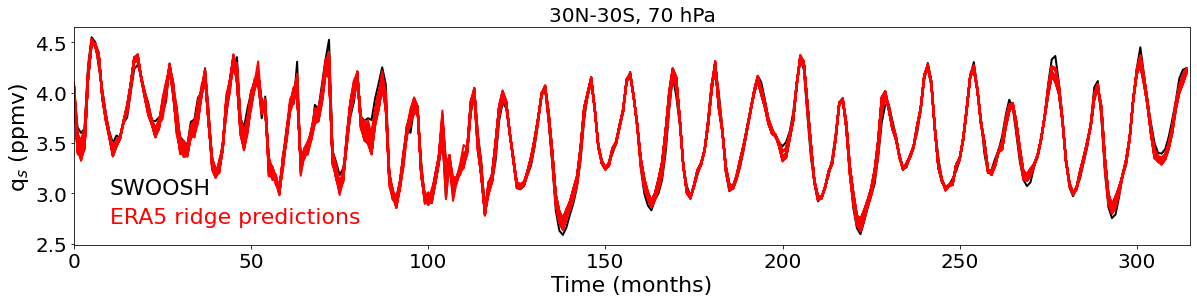

In [28]:
### plot cross-validated ERA5 predictions on top of the actual SWOOSH data (black)
plt.rcParams['figure.figsize'] = [20, 4]
plt.plot(np.arange(0,315),np.mean(swoosh_tropics_processed[:,:],axis=1)[non_nan_indices],color='k',linewidth=2)
for i in range(0,n_swoosh):
    plt.plot(np.arange(0,315),era5_predictions[i,:],color='r',linewidth=2)
plt.xticks(fontsize=20)
plt.yticks([2.5,3.0,3.5,4.0,4.5],fontsize=20)
plt.xlabel('Time (months)',size=22)
plt.ylabel('q$_s$ (ppmv)',size=22)
plt.title('30N-30S, 70 hPa',size=20)
plt.xlim(0,315)
plt.figtext(0.15,0.3,'SWOOSH',color='k',size=22)
plt.figtext(0.15,0.2,'ERA5 ridge predictions',color='r',size=22)
# plt.savefig('./figures/ERA5_predictions_historical.pdf',dpi=300)
# plt.savefig('./figures/ERA5_predictions_historical.png',dpi=300)

In [31]:
### fit observations using MERRA2 temperatures
X_lag_hist_merra = np.hstack((X_raw_hist_merra[lag:,:],X_raw_hist_merra[lag-1:-1,:],X_raw_hist_merra[lag-2:-2,:]))
### last year missing for MERRA-2, see Online Methods in paper
X_lag_hist_merra_swoosh = X_lag_hist_merra[non_nan_indices_lag[:-12]]
print(X_lag_hist_merra_swoosh.shape)
scaler_merra = StandardScaler()
x_scaler_merra = scaler_merra.fit(X_lag_hist_merra_swoosh[:,:])
X_train_norm_merra = x_scaler_merra.transform(X_lag_hist_merra_swoosh[:,:])
merra_models = {}
merra_alphas = []
merra_predictions = np.empty((n_swoosh,X_lag_hist_merra_swoosh.shape[0]))
for i in range(0,n_swoosh):
    swoosh_tropics_log = np.log(swoosh_tropics_processed[lag:,i])
    ### adjust for lack of 2020 data
    swoosh_tropics_log_no_nan = swoosh_tropics_log[non_nan_indices_lag[:-12]]
    regressors_col = {}
    parameters = {
    'alpha': alpha_i,
    'fit_intercept': [True],
    'max_iter':[1000],
    'random_state':[100]
             }
    cv_obj = KFold(n_splits=5,shuffle=False)
    regr_obs_merra = GridSearchCV(Ridge(),parameters,cv=cv_obj,n_jobs=-1,refit=True)
    regr_obs_merra.fit(X_train_norm_merra[:,:],swoosh_tropics_log_no_nan[:])
    merra_models['model_'+str(i)] = regr_obs_merra.best_estimator_
    merra_alphas.append(regr_obs_merra.best_estimator_.alpha)
    merra_predictions[i,:] = np.exp(regr_obs_merra.best_estimator_.predict(X_train_norm_merra[:,:]))

(303, 25920)


Text(0.15, 0.2, 'MERRA-2 ridge predictions')

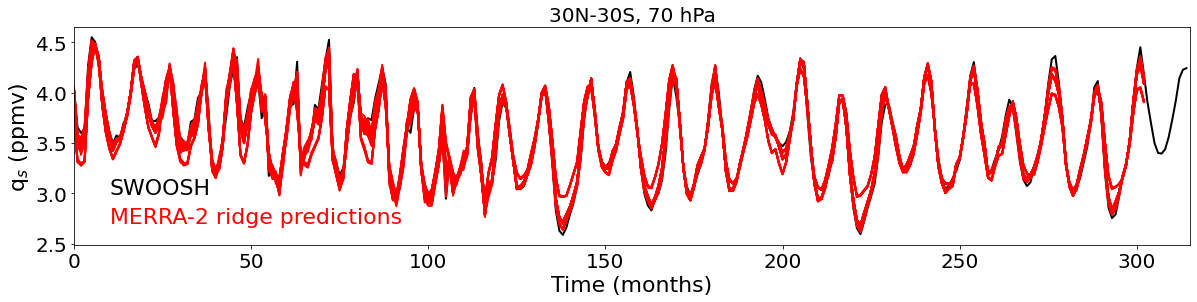

In [33]:
### plot cross-validated MERRA2 predictions on top of the actual SWOOSH data (black)
nt=303
plt.plot(np.arange(0,315),np.mean(swoosh_tropics_processed[:,:],axis=1)[non_nan_indices],color='k',linewidth=2)
for i in range(0,n_swoosh):
    plt.plot(np.arange(0,nt),merra_predictions[i,:],color='r',linewidth=2)
plt.xticks(fontsize=20)
plt.yticks([2.5,3.0,3.5,4.0,4.5],fontsize=20)
plt.xlabel('Time (months)',size=22)
plt.ylabel('q$_s$ (ppmv)',size=22)
plt.title('30N-30S, 70 hPa',size=20)
plt.xlim(0,315)
plt.figtext(0.15,0.3,'SWOOSH',color='k',size=22)
plt.figtext(0.15,0.2,'MERRA-2 ridge predictions',color='r',size=22)
# plt.savefig('./figures/MERRA2_predictions_historical.pdf',dpi=300)
# plt.savefig('./figures/MERRA2_predictions_historical.png',dpi=300)

In [34]:
### fit observations; first train using JRA-55 data for temperature
X_lag_hist_jra = np.hstack((X_raw_hist_jra[lag:,:],X_raw_hist_jra[lag-1:-1,:],X_raw_hist_jra[lag-2:-2,:]))
X_lag_hist_jra_swoosh = X_lag_hist_jra[non_nan_indices_lag]
n_swoosh = swoosh_tropics_processed.shape[1]
print(X_lag_hist_jra_swoosh.shape)
scaler_jra = StandardScaler()
x_scaler_jra = scaler_jra.fit(X_lag_hist_jra_swoosh[:,:])
X_train_norm_jra = x_scaler_jra.transform(X_lag_hist_jra_swoosh[:,:])
jra_models = {}
jra_alphas = []
jra_predictions = np.empty((n_swoosh,X_lag_hist_jra_swoosh.shape[0]))
for i in range(0,n_swoosh):
    swoosh_tropics_log = np.log(swoosh_tropics_processed[lag:,i])
    swoosh_tropics_log_no_nan = swoosh_tropics_log[non_nan_indices_lag]
#     print(swoosh_tropics_log_Will.shape)
    regressors_col = {}
    parameters = {
    'alpha': alpha_i,
    'fit_intercept': [True],
    'max_iter':[1000],
    'random_state':[100]
             }
    cv_obj = KFold(n_splits=5,shuffle=False)
    regr_obs_jra = GridSearchCV(Ridge(),parameters,cv=cv_obj,n_jobs=-1,refit=True)
    regr_obs_jra.fit(X_train_norm_jra[:,:],swoosh_tropics_log_no_nan[:])
    jra_models['model_'+str(i)] = regr_obs_jra.best_estimator_
    jra_alphas.append(regr_obs_jra.best_estimator_.alpha)
    jra_predictions[i,:] = np.exp(regr_obs_jra.best_estimator_.predict(X_train_norm_jra[:,:]))

(315, 25920)


Text(0.15, 0.2, 'JRA-55 ridge predictions')

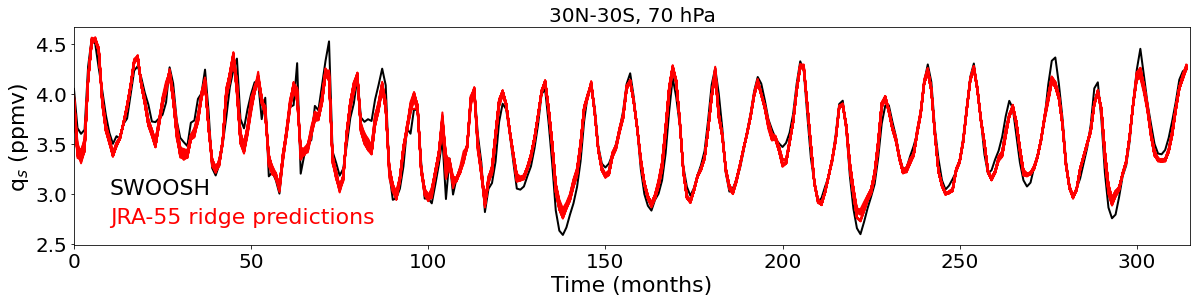

In [38]:
### plot cross-validated JRA-55 predictions on top of the actual SWOOSH data (black)
nt=315
plt.plot(np.arange(0,315),np.mean(swoosh_tropics_processed[:,:],axis=1)[non_nan_indices],color='k',linewidth=2)
for i in range(0,n_swoosh):
    plt.plot(np.arange(0,nt),jra_predictions[i,:],color='r',linewidth=2)
plt.xticks(fontsize=20)
plt.yticks([2.5,3.0,3.5,4.0,4.5],fontsize=20)
plt.xlabel('Time (months)',size=22)
plt.ylabel('q$_s$ (ppmv)',size=22)
plt.title('30N-30S, 70 hPa',size=20)
plt.xlim(0,nt)
plt.figtext(0.15,0.3,'SWOOSH',color='k',size=22)
plt.figtext(0.15,0.2,'JRA-55 ridge predictions',color='r',size=22)
# plt.savefig('./figures/JRA55_predictions_historical.pdf',dpi=300)
# plt.savefig('./figures/JRA55_predictions_historical.png',dpi=300)

In [39]:
### save results
dict_regr_results_reanalyses = {}
dict_regr_results_reanalyses['era5'] = era5_models
dict_regr_results_reanalyses['merra'] = merra_models
dict_regr_results_reanalyses['jra'] = jra_models
joblib.dump(dict_regr_results_reanalyses,'./data/results/reanalyses_three_50models_each_60NS_finalNatGeo.pkl')

['./data/results/reanalyses_three_50models_each_60NS_finalNatGeo.pkl']

In [40]:
### next step is to combine reanalysis functions with CMIP5/6 temperature changes under 4xCO2
### need a few model lists for mis-matching time periods etc below, see also file CMIP_models_ridge_training_T60NS_5plevs.ipynb
model_list = ['ACCESS1-0', 'ACCESS1-3', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'bcc-csm1-1_',
             'bcc-csm1-1-m','BCC-CSM2-MR_', 'BCC-ESM1', 'BNU-ESM', 'CAMS-CSM1-0', 'CanESM2', 'CanESM5',
             'CCSM4', 'CESM2_', 'CESM2-WACCM', 'CNRM-CM5', 'CNRM-CM6-1','CNRM-ESM2-1','CSIRO-Mk3-6-0', 'E3SM-1-0', 'EC-Earth3-Veg', 'EC-EARTH', 'FGOALS-f3-L', 'FGOALS-g2', 'FGOALS-g3', 
             'GFDL-CM3', 'GFDL-CM4', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GFDL-ESM4',
             'GISS-E2-1-G', 'GISS-E2-1-H', 'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-ES', 'HadGEM3-GC31-LL',
             'HadGEM3-GC31-MM', 'inmcm4', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'IPSL-CM6A-LR',
             'MIROC5', 'MIROC6', 'MIROC-ES2L', 'MIROC-ESM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MPI-ESM-P', 'MRI-CGCM3',
             'MRI-ESM2-0', 'NESM3', 'NorESM1-M', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'UKESM1-0-LL']

model_list_cmip5 = ['ACCESS1-0', 'ACCESS1-3', 'bcc-csm1-1_', 'bcc-csm1-1-m', 'BNU-ESM', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'EC-EARTH', 'FGOALS-g2', 'GFDL-CM3', 
               'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC5', 'MIROC-ESM', 'MPI-ESM-LR', 'MPI-ESM-MR', 
                    'MPI-ESM-P', 'MRI-CGCM3', 'NorESM1-M']
model_list_cmip5_1968 = ['MPI-ESM-P']
model_list_cmip5_labels = ['ACCESS1-0', 'ACCESS1-3', 'BCC-CSM1-1', 'BCC-CSM1-1-m', 'BNU-ESM', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'EC-EARTH', 'FGOALS-g2', 
                           'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-ES', 'INM-CM4', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC5', 'MIROC-ESM', 'MPI-ESM-LR', 'MPI-ESM-MR',
                           'MPI-ESM-P','MRI-CGCM3', 'NorESM1-M']

model_list_cmip6 = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR_', 'BCC-ESM1', 'CAMS-CSM1-0', 'CanESM5',
             'CESM2_', 'CESM2-WACCM', 'CNRM-CM6-1','CNRM-ESM2-1', 'E3SM-1-0', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3', 
             'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-H', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
             'MIROC6', 'MIROC-ES2L', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'UKESM1-0-LL']
model_list_cmip6_1977 = ['CESM2_', 'E3SM-1-0', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3', 'GISS-E2-1-H', 'HadGEM3-GC31-LL', 
                         'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0', 'MIROC-ES2L', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON']
model_list_cmip6_labels = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CanESM5',
             'CESM2', 'CESM2-WACCM', 'CNRM-CM6-1','CNRM-ESM2-1', 'E3SM-1-0', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3', 
             'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-H', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
             'MIROC6', 'MIROC-ES2L', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'UKESM1-0-LL']

In [41]:
nr_models = len(model_list)
print(nr_models)

61


In [44]:
### below we estimate the feedbacks (SWV trends per degree global warming; not radiative feedbacks - those are calculated separately in radiative transfer calculations)
### first obs functions combined with model temperature responses
feedbacks_era = np.empty((nr_models,n_swoosh))
feedbacks_merra = np.empty((nr_models,n_swoosh))
feedbacks_jra = np.empty((nr_models,n_swoosh))
### also save values for CMIP5/6 models
feedbacks_true = np.empty((nr_models))
feedbacks_pred = np.empty((nr_models))

In [45]:
### load ridge regression models trained on CMIP data
results_dict = joblib.load('./data/results/models_lag2_5planes_60NS_all_models_final.pkl')

In [46]:
months = np.array(non_nan_indices_lag.flatten())
for modeli in range(0,nr_models):
    print(model_list[modeli])
    ### read in trained CMIP model results
    regr_model = results_dict[model_list[modeli]][0].best_estimator_
    X_raw_hist = netCDF4.Dataset(glob.glob('./data/cmip/ta/ta*'+model_list[modeli]+'*historical*.nc')[0])['ta'][nt_train_start:nt_train_end,1:nr_planes-1,la:lb,:]
    ###selected 70hPa for SWV
    level_selected=1
    nt_4xco2 = 1800
    ### need historical data just to recover the X-scaling
    X_raw_hist = X_raw_hist.reshape(X_raw_hist.shape[0],nr_lon*nr_lat*(nr_planes-2))
    print(X_raw_hist.shape,'hist T before selection')
    X_lag_hist = np.hstack((X_raw_hist[lag:,:],X_raw_hist[lag-1:-1,:],X_raw_hist[lag-2:-2,:]))
    if model_list[modeli] in model_list_cmip5_1968:
### first 192 months can be considered fully covered for the model, similar to the last 192 months in SWOOSH. Critical is the masking covering Pinatubo
        shifted_months = months[:-192]+192
        months_modeli = np.concatenate([np.arange(0,192),shifted_months])
    elif model_list[modeli] in model_list_cmip6_1977:
        shifted_months = months[:-84]+84
        months_modeli = np.concatenate([np.arange(0,84),shifted_months])
    else:
        months_modeli = months
    X_lag_hist_swoosh = X_lag_hist[months_modeli,:]
    print(X_lag_hist_swoosh.shape,', after lagging and selection')
    ### re-fit X-scaling
    scaler_hist = StandardScaler()
    x_scaler_hist = scaler_hist.fit(X_lag_hist_swoosh[:,:])  
    ### now load model-consistent 4xCO2 data
    X_raw_4xco2 = netCDF4.Dataset(glob.glob('./data/cmip/ta/ta*'+model_list[modeli]+'*4xCO2*.nc')[0])['ta'][:nt_4xco2,1:nr_planes-1,la:lb,:]
    Y_raw_4xco2 = netCDF4.Dataset(glob.glob('./data/cmip/hus/hus*'+model_list[modeli]+'*4xCO2*.nc')[0])['hus'][:nt_4xco2,level_selected,0,0]*1e6/0.6213
#### some models might not have been run for the whole 150 years under 4xCO2 (e.g. IPSL)
    nt_4xco2 = Y_raw_4xco2.shape[0]
    X_raw_4xco2 = X_raw_4xco2.reshape(nt_4xco2,nr_lon*nr_lat*(nr_planes-2))
    X_lag_4xco2 = np.hstack((X_raw_4xco2[lag:,:],X_raw_4xco2[lag-1:-1,:],X_raw_4xco2[lag-2:-2,:]))
### scale according to historical data and re-scale standard deviations for models for use in observed functions (amplitudes of anomalies should be seen as such)
    X_lag_4xco2_norm = x_scaler_hist.transform(X_lag_4xco2)
    X_lag_4xco2_norm_era = X_lag_4xco2_norm*np.sqrt(x_scaler_hist.var_)/np.sqrt(x_scaler_era5.var_)
    X_lag_4xco2_norm_merra = X_lag_4xco2_norm*np.sqrt(x_scaler_hist.var_)/np.sqrt(x_scaler_merra.var_)
    X_lag_4xco2_norm_jra = X_lag_4xco2_norm*np.sqrt(x_scaler_hist.var_)/np.sqrt(x_scaler_jra.var_)
### predict CMIP-model consistent with coefficients trained on historical data
    y_4xco2_pred = np.exp(regr_model.predict(X_lag_4xco2_norm))
    ### create empty containers for predictions: n_swoosh = 50 different ones per reanalysis - using 'observed' coefficients
    y_4xco2_pred_era = np.empty((X_lag_4xco2_norm.shape[0],n_swoosh))
    y_4xco2_pred_merra = np.empty((X_lag_4xco2_norm.shape[0],n_swoosh))
    y_4xco2_pred_jra = np.empty((X_lag_4xco2_norm.shape[0],n_swoosh))
    for i in range(0,n_swoosh):
        y_4xco2_pred_era[:,i] = np.exp(era5_models['model_'+str(i)].predict(X_lag_4xco2_norm_era))
        y_4xco2_pred_merra[:,i] = np.exp(merra_models['model_'+str(i)].predict(X_lag_4xco2_norm_merra))
        y_4xco2_pred_jra[:,i] = np.exp(jra_models['model_'+str(i)].predict(X_lag_4xco2_norm_jra))
    ### calculate annual means from monthly mean predictions / global mean surface temperature
    y_pred_am = np.empty((int((y_4xco2_pred.shape[0]-12+lag)/12)))
    y_true_am = np.empty((int((y_4xco2_pred.shape[0]-12+lag)/12)))
    y_pred_am_era = np.empty((int((y_4xco2_pred.shape[0]-12+lag)/12),n_swoosh))
    y_pred_am_merra = np.empty((int((y_4xco2_pred.shape[0]-12+lag)/12),n_swoosh))
    y_pred_am_jra = np.empty((int((y_4xco2_pred.shape[0]-12+lag)/12),n_swoosh))
    tas_4xco2 = netCDF4.Dataset(glob.glob('./data/cmip/tas/tas_global_mean/tas*'+model_list[modeli]+'*4xCO2*.nc')[0])['tas'][:nt_4xco2,0,0]
    tas_4xco2_am = np.empty((int((tas_4xco2.shape[0]-12)/12)))
    for i in np.arange(12,nt_4xco2,12):
        y_pred_am[int(i/12)-1] = np.mean(y_4xco2_pred[i-lag:i-lag+12])
        y_true_am[int(i/12)-1] = np.mean(Y_raw_4xco2[i:i+12])
### also select after first year
        tas_4xco2_am[int(i/12)-1] = np.mean(tas_4xco2[i:i+12],axis=0)
        for j in range(0,n_swoosh):
            y_pred_am_era[int(i/12)-1,j] = np.mean(y_4xco2_pred_era[i-lag:i-lag+12,j])
            y_pred_am_merra[int(i/12)-1,j] = np.mean(y_4xco2_pred_merra[i-lag:i-lag+12,j])
            y_pred_am_jra[int(i/12)-1,j] = np.mean(y_4xco2_pred_jra[i-lag:i-lag+12,j])
    res_mm_true_am = stats.linregress(tas_4xco2_am[:],y_true_am[:])
    feedbacks_true[modeli] = res_mm_true_am.slope
    res_mm_pred_am = stats.linregress(tas_4xco2_am[:],y_pred_am[:])
    feedbacks_pred[modeli] = res_mm_pred_am.slope    
    for i in range(0,n_swoosh):
        res_mm_pred_am_era = stats.linregress(tas_4xco2_am[:],y_pred_am_era[:,i])
        res_mm_pred_am_merra = stats.linregress(tas_4xco2_am[:],y_pred_am_merra[:,i])
        res_mm_pred_am_jra = stats.linregress(tas_4xco2_am[:],y_pred_am_jra[:,i])
        feedbacks_era[modeli,i] = res_mm_pred_am_era.slope
        feedbacks_merra[modeli,i] = res_mm_pred_am_merra.slope
        feedbacks_jra[modeli,i] = res_mm_pred_am_jra.slope

ACCESS1-0
(444, 8640) hist T before selection
(315, 25920) , after lagging and selection
ACCESS1-3
(444, 8640) hist T before selection
(315, 25920) , after lagging and selection
ACCESS-CM2
(444, 8640) hist T before selection
(315, 25920) , after lagging and selection
ACCESS-ESM1-5
(444, 8640) hist T before selection
(315, 25920) , after lagging and selection
AWI-CM-1-1-MR
(444, 8640) hist T before selection
(315, 25920) , after lagging and selection
bcc-csm1-1_
(444, 8640) hist T before selection
(315, 25920) , after lagging and selection
bcc-csm1-1-m
(444, 8640) hist T before selection
(315, 25920) , after lagging and selection
BCC-CSM2-MR_
(444, 8640) hist T before selection
(315, 25920) , after lagging and selection
BCC-ESM1
(444, 8640) hist T before selection
(315, 25920) , after lagging and selection
BNU-ESM
(444, 8640) hist T before selection
(315, 25920) , after lagging and selection
CAMS-CSM1-0
(444, 8640) hist T before selection
(315, 25920) , after lagging and selection
CanES

In [47]:
import csv

In [48]:
dict_collection_results = {
    'feedbacks_true_am': feedbacks_true,
    'feedbacks_pred_am': feedbacks_pred
}
for i in range(0,n_swoosh):
    dict_collection_results['feedbacks_era5_'+str(i)] = feedbacks_era[:,i]
    dict_collection_results['feedbacks_merra_'+str(i)] = feedbacks_merra[:,i]
    dict_collection_results['feedbacks_jra'+str(i)] = feedbacks_jra[:,i]

In [49]:
df_results = pd.DataFrame(data=dict_collection_results)
df_results.index = model_list

In [50]:
df_results

,feedbacks_true_am,feedbacks_pred_am,feedbacks_era5_0,feedbacks_merra_0,feedbacks_jra0,feedbacks_era5_1,feedbacks_merra_1,feedbacks_jra1,feedbacks_era5_2,feedbacks_merra_2,...,feedbacks_jra46,feedbacks_era5_47,feedbacks_merra_47,feedbacks_jra47,feedbacks_era5_48,feedbacks_merra_48,feedbacks_jra48,feedbacks_era5_49,feedbacks_merra_49,feedbacks_jra49
ACCESS1-0,0.773901,0.579223,0.230671,0.067362,0.317184,0.129907,0.020735,0.309755,0.138390,0.013624,...,0.314317,0.155930,0.030305,0.313902,0.137817,-0.070209,0.319911,0.211848,0.028605,0.334141
ACCESS1-3,0.339824,0.133675,0.307698,0.101427,0.447847,0.190157,0.061824,0.439360,0.204701,0.052563,...,0.445324,0.224755,0.072005,0.445834,0.200848,-0.044363,0.450745,0.291676,0.071336,0.482023
ACCESS-CM2,1.238250,1.271783,0.327180,0.074170,0.662258,0.218252,0.039763,0.644689,0.225204,0.028993,...,0.656269,0.246549,0.046791,0.653108,0.233219,-0.043431,0.666662,0.308405,0.048827,0.706973
ACCESS-ESM1-5,0.339732,0.351980,0.219482,0.027688,0.391720,0.131218,0.002446,0.382843,0.138014,-0.006918,...,0.389127,0.157966,0.012342,0.390141,0.142033,-0.058739,0.394610,0.207345,0.012061,0.415703
AWI-CM-1-1-MR,0.599236,0.449511,0.344808,0.140870,0.480766,0.224916,0.093073,0.469865,0.239364,0.081878,...,0.476198,0.254345,0.099719,0.474032,0.238072,-0.022298,0.483323,0.324655,0.099534,0.504953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NorESM1-M,0.292601,0.157784,0.234446,0.084177,0.297715,0.157798,0.053168,0.292830,0.163944,0.046214,...,0.293879,0.176397,0.059680,0.295145,0.163861,-0.029841,0.298273,0.220689,0.060522,0.310005
NorESM2-LM,0.239945,0.227531,0.254371,0.059173,0.449258,0.177427,0.040590,0.444349,0.166609,0.019231,...,0.446419,0.192325,0.040889,0.445190,0.178215,-0.046915,0.448398,0.248738,0.047089,0.469514
NorESM2-MM,0.338866,0.257713,0.221712,0.017056,0.411836,0.153827,0.000072,0.404556,0.135994,-0.022100,...,0.408009,0.167466,0.004222,0.408863,0.153830,-0.065211,0.407538,0.215186,0.011135,0.420989
SAM0-UNICON,0.439915,0.561578,0.260749,0.048956,0.424770,0.156194,0.005634,0.415825,0.159593,-0.005988,...,0.424103,0.187731,0.016646,0.425978,0.163656,-0.081578,0.426584,0.243574,0.013276,0.451883


In [52]:
### save all feedback results
df_results.to_csv('./data/results/SVW_feedback_results_60NS_allmodels_315samples_50_realisations_SWOOSH_finalNatGeo.csv')